In [1]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
train_dir = pathlib.Path('../input/intel-image-classification/seg_train/seg_train')
val_dir = pathlib.Path('../input/intel-image-classification/seg_test/seg_test')

In [4]:
t_img_c = len(list(train_dir.glob('*/*.jpg')))
v_img_c = len(list(val_dir.glob('*/*.jpg')))
print(t_img_c, v_img_c)

14034 3000


In [5]:
batch_size = 32
img_height = 150
img_width = 150

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory as load_dataset

In [8]:
train_ds = load_dataset(
    train_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.


In [9]:
val_ds = load_dataset(
    val_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3000 files belonging to 6 classes.


In [10]:
class_names = train_ds.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [19]:
num_classes = 6

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)       

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

Epoch 1/20
439/439 [==============================] - 6s 13ms/step - loss: 1.3254 - accuracy: 0.4980 - val_loss: 0.8284 - val_accuracy: 0.7030
Epoch 2/20
439/439 [==============================] - 5s 12ms/step - loss: 0.8574 - accuracy: 0.6800 - val_loss: 0.8557 - val_accuracy: 0.7003
Epoch 3/20
439/439 [==============================] - 5s 12ms/step - loss: 0.7606 - accuracy: 0.7150 - val_loss: 0.7676 - val_accuracy: 0.7227
Epoch 4/20
439/439 [==============================] - 5s 12ms/step - loss: 0.7021 - accuracy: 0.7430 - val_loss: 0.6555 - val_accuracy: 0.7680
Epoch 5/20
439/439 [==============================] - 5s 12ms/step - loss: 0.6409 - accuracy: 0.7637 - val_loss: 0.6263 - val_accuracy: 0.7780
Epoch 6/20
439/439 [==============================] - 5s 12ms/step - loss: 0.6070 - accuracy: 0.7789 - val_loss: 0.7110 - val_accuracy: 0.7460
Epoch 7/20
439/439 [==============================] - 5s 12ms/step - loss: 0.5716 - accuracy: 0.7903 - val_loss: 0.6502 - val_accuracy: 0.7730

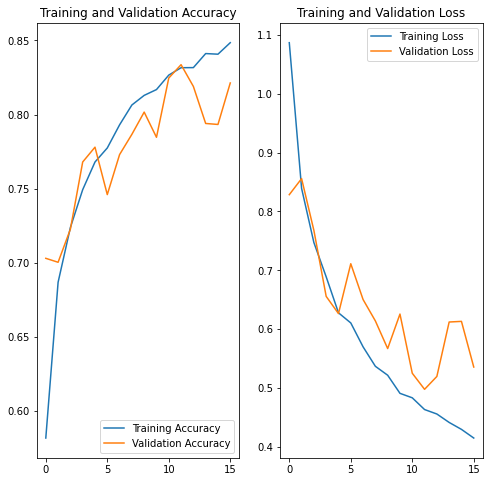

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
def make_pred(file_path):
    img = keras.preprocessing.image.load_img(
        file_path, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [33]:
file_path = "../input/intel-image-classification/seg_pred/seg_pred/10012.jpg"
make_pred(file_path)

This image most likely belongs to street with a 81.93 percent confidence.


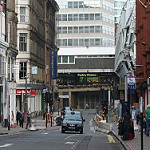

In [34]:
PIL.Image.open(file_path)

In [35]:
file_path = "../input/intel-image-classification/seg_pred/seg_pred/10013.jpg"
make_pred(file_path)

This image most likely belongs to mountain with a 69.89 percent confidence.


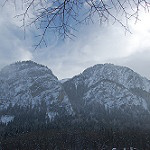

In [36]:
PIL.Image.open(file_path)

In [37]:
file_path = "../input/intel-image-classification/seg_pred/seg_pred/10017.jpg"
make_pred(file_path)

This image most likely belongs to glacier with a 39.14 percent confidence.


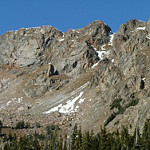

In [38]:
PIL.Image.open(file_path)

In [39]:
file_path = "../input/intel-image-classification/seg_pred/seg_pred/10005.jpg"
make_pred(file_path)

This image most likely belongs to mountain with a 89.46 percent confidence.


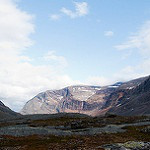

In [40]:
PIL.Image.open(file_path)

In [41]:
file_path = "../input/intel-image-classification/seg_pred/seg_pred/10079.jpg"
make_pred(file_path)

This image most likely belongs to street with a 99.94 percent confidence.


In [ ]:
PIL.Image.open(file_path)